In [67]:
# Import Library untuk Neuro Computing dengan PyTorch
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings('ignore')

# Set random seed untuk reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Menggunakan device: {device}")

Menggunakan device: cpu


In [68]:
# Import Data
data = pd.read_csv('vehicle_counts_fuzzy_clustered.csv')

# Preprocessing awal
def cluster_label(cluster):
    if cluster == 1:
        return "Lancar"
    elif cluster == 2:
        return "Padat"
    else:
        return "Macet"

data["cluster"] = data["cluster"].apply(cluster_label)

# Filter data dan persiapan
data = data[['datetime_end', 'ocr_raw', 'count_of_car', 'count_of_motorcycle', 'count_of_heavy', 'cluster']]
data['datetime_end'] = pd.to_datetime(data['datetime_end'])
filter_data = data[data['datetime_end'].dt.minute == 10]
filter_data['vehicle_count'] = filter_data['count_of_car'] + filter_data['count_of_motorcycle'] + filter_data['count_of_heavy']
filter_data.to_csv('data_klasifikasi.csv', index=False)
data = pd.read_csv('data_klasifikasi.csv')
data = data.drop_duplicates()

In [69]:
# Enhanced Feature Engineering untuk Neural Network
print("=== NEURO COMPUTING FEATURE ENGINEERING ===")
X_enhanced = data[['count_of_car', 'count_of_motorcycle', 'count_of_heavy', 'vehicle_count']].copy()

# Ratio features
X_enhanced['motorcycle_ratio'] = X_enhanced['count_of_motorcycle'] / (X_enhanced['vehicle_count'] + 1e-8)
X_enhanced['car_ratio'] = X_enhanced['count_of_car'] / (X_enhanced['vehicle_count'] + 1e-8)
X_enhanced['heavy_ratio'] = X_enhanced['count_of_heavy'] / (X_enhanced['vehicle_count'] + 1e-8)

# Interaction features
X_enhanced['car_motorcycle_interaction'] = X_enhanced['count_of_car'] * X_enhanced['count_of_motorcycle']
X_enhanced['density_score'] = X_enhanced['count_of_car'] * 2 + X_enhanced['count_of_motorcycle'] * 1 + X_enhanced['count_of_heavy'] * 3

# Polynomial features
X_enhanced['vehicle_count_squared'] = X_enhanced['vehicle_count'] ** 2
X_enhanced['car_squared'] = X_enhanced['count_of_car'] ** 2

# Statistical features
X_enhanced['vehicle_variety'] = (X_enhanced['count_of_car'] > 0).astype(int) + (X_enhanced['count_of_motorcycle'] > 0).astype(int) + (X_enhanced['count_of_heavy'] > 0).astype(int)

X = X_enhanced
print(f"Shape setelah feature engineering: {X.shape}")
print(f"Features: {list(X.columns)}")

=== NEURO COMPUTING FEATURE ENGINEERING ===
Shape setelah feature engineering: (138, 12)
Features: ['count_of_car', 'count_of_motorcycle', 'count_of_heavy', 'vehicle_count', 'motorcycle_ratio', 'car_ratio', 'heavy_ratio', 'car_motorcycle_interaction', 'density_score', 'vehicle_count_squared', 'car_squared', 'vehicle_variety']


In [70]:
# Target preparation
y = data[['cluster']]
le = LabelEncoder()
y_encoded = le.fit_transform(y.values.ravel())
classes = le.classes_
num_classes = len(classes)

print(f"\nClass distribution: {pd.Series(y_encoded).value_counts()}")
print(f"Classes: {classes}")
print(f"Number of classes: {num_classes}")

# Calculate class weights untuk handle imbalance
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_encoded),
    y=y_encoded
)
class_weight_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)
print(f"Class weights: {class_weights}")

# Train-Test Split dengan stratification
print("\n=== DATA SPLITTING ===")
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, 
    test_size=0.2, 
    random_state=42,
    stratify=y_encoded
)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")


Class distribution: 2    58
0    43
1    37
Name: count, dtype: int64
Classes: ['Lancar' 'Macet' 'Padat']
Number of classes: 3
Class weights: [1.06976744 1.24324324 0.79310345]

=== DATA SPLITTING ===
Training set size: (110, 12)
Test set size: (28, 12)


In [71]:
# Pengecekan Data Leakage
print("\n" + "="*50)
print("PENGECEKAN DATA LEAKAGE")
print("="*50)

# 1. Periksa ukuran dan overlap antara train dan test set
print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

# Cek apakah ada baris yang sama (overlap) antara X_train dan X_test
# Menggunakan pandas untuk perbandingan (asumsi data numerik)
overlap = X_train.merge(X_test, how='inner', indicator=True)
if overlap.empty:
    print("✓ Tidak ada overlap (leakage) antara training dan test set.")
else:
    print(f"⚠ Ada {len(overlap)} baris overlap antara training dan test set. Periksa data splitting!")
    print("Contoh overlap:")
    print(overlap.head())

# 2. Periksa duplikasi dalam dataset keseluruhan
total_duplicates = data.duplicated().sum()
print(f"Jumlah duplikasi dalam dataset keseluruhan: {total_duplicates}")
if total_duplicates > 0:
    print("⚠ Ada duplikasi data. Pastikan tidak menyebabkan leakage saat splitting.")

# 3. Periksa statistik dasar untuk indikasi leakage (misalnya, distribusi yang terlalu mirip)
print("\nStatistik dasar X_train:")
print(X_train.describe())
print("\nStatistik dasar X_test:")
print(X_test.describe())

# Jika distribusi terlalu mirip, bisa jadi indikasi leakage (tapi ini subjektif)
train_mean = X_train.mean()
test_mean = X_test.mean()
diff_mean = abs(train_mean - test_mean)
print(f"\nPerbedaan rata-rata fitur antara train dan test (abs): {diff_mean}")
if diff_mean.max() < 0.1:  # Threshold sederhana, sesuaikan jika perlu
    print("⚠ Distribusi rata-rata terlalu mirip; periksa potensi leakage.")
else:
    print("✓ Distribusi rata-rata cukup berbeda; kemungkinan tidak ada leakage.")

# 4. Opsional: Gunakan cross-validation untuk deteksi leakage (dengan sklearn)
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression  # Model sederhana untuk check

# Buat model dummy untuk cross-validation
dummy_model = LogisticRegression(max_iter=1000)
scores = cross_val_score(dummy_model, X, y_encoded, cv=5, scoring='accuracy')
print(f"\nCross-validation scores (LogisticRegression): {scores}")
print(f"Mean CV accuracy: {scores.mean():.4f}")
if scores.std() > 0.1:  # Jika variansi tinggi, mungkin ada leakage atau imbalance
    print("⚠ Varian tinggi dalam CV; periksa data atau leakage.")
else:
    print("✓ CV scores stabil; kemungkinan tidak ada leakage.")

print("\nPengecekan selesai. Jika ada peringatan, perbaiki sebelum training.")



PENGECEKAN DATA LEAKAGE
Training set size: (110, 12)
Test set size: (28, 12)
✓ Tidak ada overlap (leakage) antara training dan test set.
Jumlah duplikasi dalam dataset keseluruhan: 0

Statistik dasar X_train:
       count_of_car  count_of_motorcycle  count_of_heavy  vehicle_count  \
count    110.000000           110.000000      110.000000     110.000000   
mean      16.290909            51.627273        0.345455      68.263636   
std       11.538007            37.459424        0.913069      46.403234   
min        0.000000             0.000000        0.000000       0.000000   
25%        5.000000            20.250000        0.000000      27.750000   
50%       17.000000            46.000000        0.000000      66.000000   
75%       25.000000            78.500000        0.000000     101.750000   
max       43.000000           163.000000        7.000000     191.000000   

       motorcycle_ratio   car_ratio  heavy_ratio  car_motorcycle_interaction  \
count        110.000000  110.00000

In [72]:
# Scaling untuk Neural Network
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create DataLoader
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"\nInput shape: {X_train_tensor.shape[1]}")
print(f"Output shape: {num_classes}")


Input shape: 12
Output shape: 3


In [73]:
# MODEL 1: Deep Neural Network Dasar
print("\n" + "="*50)
print("MODEL 1: DEEP NEURAL NETWORK")
print("="*50)

class DNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(DNN, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

dnn_model = DNN(X_train_tensor.shape[1], num_classes).to(device)
print(dnn_model)


MODEL 1: DEEP NEURAL NETWORK
DNN(
  (network): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=32, bias=True)
    (9): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Dropout(p=0.2, inplace=False)
    (12): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [74]:
# MODEL 2: Advanced Neural Network dengan Residual Connections
print("\n" + "="*50)
print("MODEL 2: ADVANCED NEURAL NETWORK")
print("="*50)

class ResidualBlock(nn.Module):
    def __init__(self, input_size, output_size):
        super(ResidualBlock, self).__init__()
        self.linear1 = nn.Linear(input_size, output_size)
        self.bn1 = nn.BatchNorm1d(output_size)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(output_size, output_size)
        self.bn2 = nn.BatchNorm1d(output_size)
        
        # Skip connection
        self.skip = nn.Linear(input_size, output_size) if input_size != output_size else nn.Identity()
    
    def forward(self, x):
        identity = self.skip(x)
        out = self.linear1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.linear2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out

class AdvancedNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(AdvancedNN, self).__init__()
        self.input_layer = nn.Sequential(
            nn.Linear(input_size, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4)
        )
        
        self.residual1 = ResidualBlock(256, 128)
        self.residual2 = ResidualBlock(128, 64)
        
        self.output_layer = nn.Sequential(
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        x = self.input_layer(x)
        x = self.residual1(x)
        x = self.residual2(x)
        x = self.output_layer(x)
        return x

advanced_model = AdvancedNN(X_train_tensor.shape[1], num_classes).to(device)
print(advanced_model)


MODEL 2: ADVANCED NEURAL NETWORK
AdvancedNN(
  (input_layer): Sequential(
    (0): Linear(in_features=12, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.4, inplace=False)
  )
  (residual1): ResidualBlock(
    (linear1): Linear(in_features=256, out_features=128, bias=True)
    (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (linear2): Linear(in_features=128, out_features=128, bias=True)
    (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (skip): Linear(in_features=256, out_features=128, bias=True)
  )
  (residual2): ResidualBlock(
    (linear1): Linear(in_features=128, out_features=64, bias=True)
    (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (linear2): Linear(in_features=64, out_features=64, bias=True)
    

In [75]:
# MODEL 3: Wide & Deep Neural Network
print("\n" + "="*50)
print("MODEL 3: WIDE & DEEP NEURAL NETWORK")
print("="*50)

class WideDeepNN(nn.Module):
    def __init__(self, input_size, num_classes):
        super(WideDeepNN, self).__init__()
        # Wide pathway (linear)
        self.wide = nn.Linear(input_size, 64)
        
        # Deep pathway (non-linear)
        self.deep = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.2)
        )
        
        # Combined layers
        self.combined = nn.Sequential(
            nn.Linear(128, 32),  # 64 (wide) + 64 (deep) = 128
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, num_classes)
        )
    
    def forward(self, x):
        wide_out = self.wide(x)
        deep_out = self.deep(x)
        combined = torch.cat([wide_out, deep_out], dim=1)
        output = self.combined(combined)
        return output

wide_deep_model = WideDeepNN(X_train_tensor.shape[1], num_classes).to(device)
print(wide_deep_model)


MODEL 3: WIDE & DEEP NEURAL NETWORK
WideDeepNN(
  (wide): Linear(in_features=12, out_features=64, bias=True)
  (deep): Sequential(
    (0): Linear(in_features=12, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.2, inplace=False)
  )
  (combined): Sequential(
    (0): Linear(in_features=128, out_features=32, bias=True)
    (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=3, bias=True)
  )
)


In [76]:
# Cell 13

# Training Function yang sudah diperbaiki (Menggunakan Gradient Descent - SGD)
def train_model(model, train_loader, test_loader, model_name, num_epochs=300):
    print(f"\n=== TRAINING {model_name} DENGAN GRADIENT DESCENT (SGD) ===")
    
    criterion = nn.CrossEntropyLoss(weight=class_weight_tensor)
    # Menggunakan SGD sebagai Gradient Descent standar
    optimizer = optim.SGD(model.parameters(), lr=0.01)  # Learning rate kecil untuk stabilitas
    
    train_losses = []
    train_accuracies = []
    test_accuracies = []
    
    best_accuracy = 0
    patience = 50
    patience_counter = 0
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        total_loss = 0
        correct = 0
        total = 0
        
        for batch_X, batch_y in train_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
        
        train_accuracy = 100 * correct / total
        avg_loss = total_loss / len(train_loader)
        
        # Evaluation phase
        model.eval()
        test_correct = 0
        test_total = 0
        
        with torch.no_grad():
            for batch_X, batch_y in test_loader:
                batch_X, batch_y = batch_X.to(device), batch_y.to(device)
                outputs = model(batch_X)
                _, predicted = torch.max(outputs.data, 1)
                test_total += batch_y.size(0)
                test_correct += (predicted == batch_y).sum().item()
        
        test_accuracy = 100 * test_correct / test_total
        
        train_losses.append(avg_loss)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        
        # Early stopping
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            patience_counter = 0
            # Save best model
            torch.save(model.state_dict(), f'best_{model_name.replace(" ", "_").lower()}_sgd.pth')
        else:
            patience_counter += 1
        
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break
        
        if (epoch + 1) % 50 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}, Train Acc: {train_accuracy:.2f}%, Test Acc: {test_accuracy:.2f}%')
    
    # Load best model
    model.load_state_dict(torch.load(f'best_{model_name.replace(" ", "_").lower()}_sgd.pth'))
    
    return {
        'model': model,
        'train_losses': train_losses,
        'train_accuracies': train_accuracies,
        'test_accuracies': test_accuracies,
        'best_accuracy': best_accuracy / 100  # Convert to 0-1 scale
    }

In [77]:
# Train semua model dengan Gradient Descent (SGD)
models = {
    'Deep Neural Network': dnn_model,
    'Advanced Neural Network': advanced_model,
    'Wide & Deep Network': wide_deep_model
}

results_sgd = {}

for name, model in models.items():
    # Reset model weights jika perlu (untuk fairness comparison)
    # model.apply(lambda m: m.reset_parameters() if hasattr(m, 'reset_parameters') else None)
    results_sgd[name] = train_model(model, train_loader, test_loader, name, num_epochs=200)


=== TRAINING Deep Neural Network DENGAN GRADIENT DESCENT (SGD) ===


Epoch [50/200], Loss: 0.3904, Train Acc: 86.36%, Test Acc: 92.86%
Early stopping at epoch 79

=== TRAINING Advanced Neural Network DENGAN GRADIENT DESCENT (SGD) ===
Epoch [50/200], Loss: 0.1804, Train Acc: 95.45%, Test Acc: 92.86%
Early stopping at epoch 68

=== TRAINING Wide & Deep Network DENGAN GRADIENT DESCENT (SGD) ===
Epoch [50/200], Loss: 0.3126, Train Acc: 92.73%, Test Acc: 92.86%
Early stopping at epoch 68


In [78]:
# Evaluasi Model
print("\n" + "="*50)
print("EVALUASI SEMUA MODEL")
print("="*50)

final_results = {}

for name, result in results_sgd.items():  # Diubah dari results.items() ke results_sgd.items() untuk konsistensi dengan SGD
    model = result['model']
    model.eval()
    
    with torch.no_grad():
        test_outputs = model(X_test_tensor.to(device))
        _, test_predictions = torch.max(test_outputs, 1)
    
    test_predictions = test_predictions.cpu().numpy()
    accuracy = accuracy_score(y_test, test_predictions)
    
    final_results[name] = {
        'model': model,
        'accuracy': accuracy,
        'predictions': test_predictions,
        'best_accuracy': result['best_accuracy']
    }
    
    print(f"\n{name}:")
    print(f"Best Test Accuracy: {result['best_accuracy']:.4f}")
    print(f"Final Test Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test, test_predictions, target_names=classes))


EVALUASI SEMUA MODEL

Deep Neural Network:
Best Test Accuracy: 0.9643
Final Test Accuracy: 0.9643

Classification Report:
              precision    recall  f1-score   support

      Lancar       1.00      0.89      0.94         9
       Macet       1.00      1.00      1.00         7
       Padat       0.92      1.00      0.96        12

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.97        28
weighted avg       0.97      0.96      0.96        28


Advanced Neural Network:
Best Test Accuracy: 0.9643
Final Test Accuracy: 0.9643

Classification Report:
              precision    recall  f1-score   support

      Lancar       1.00      0.89      0.94         9
       Macet       1.00      1.00      1.00         7
       Padat       0.92      1.00      0.96        12

    accuracy                           0.96        28
   macro avg       0.97      0.96      0.97        28
weighted avg       0.97      0.96      0.96        28


Wide & De

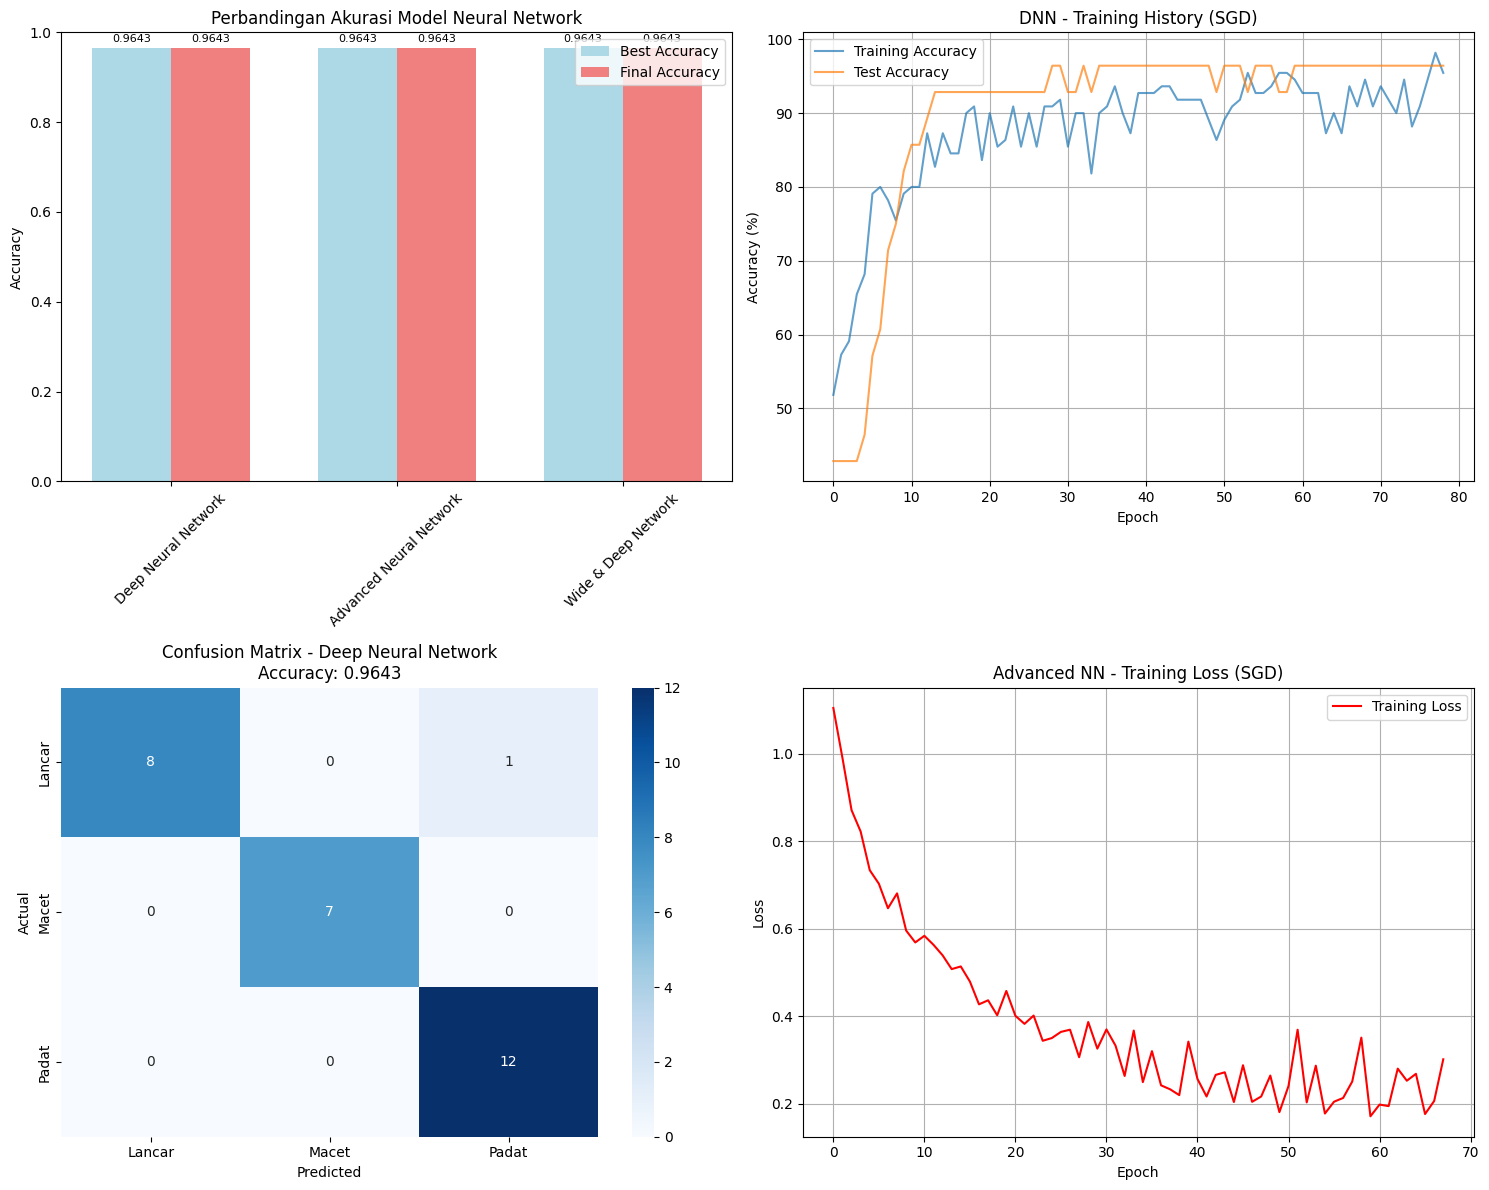

In [79]:
# Visualisasi Hasil
plt.figure(figsize=(15, 12))

# Plot 1: Perbandingan Akurasi
plt.subplot(2, 2, 1)
accuracies = [final_results[name]['accuracy'] for name in models.keys()]
best_accuracies = [final_results[name]['best_accuracy'] for name in models.keys()]

x = np.arange(len(models.keys()))
width = 0.35

plt.bar(x - width/2, best_accuracies, width, label='Best Accuracy', color='lightblue')
plt.bar(x + width/2, accuracies, width, label='Final Accuracy', color='lightcoral')

plt.title('Perbandingan Akurasi Model Neural Network')
plt.ylabel('Accuracy')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()
plt.ylim(0, 1)

for i, (best, final) in enumerate(zip(best_accuracies, accuracies)):
    plt.text(i - width/2, best + 0.01, f'{best:.4f}', ha='center', va='bottom', fontsize=8)
    plt.text(i + width/2, final + 0.01, f'{final:.4f}', ha='center', va='bottom', fontsize=8)

# Plot 2: Training History untuk DNN (dengan SGD)
plt.subplot(2, 2, 2)
plt.plot(results_sgd['Deep Neural Network']['train_accuracies'], label='Training Accuracy', alpha=0.7)  # Diubah dari results ke results_sgd
plt.plot(results_sgd['Deep Neural Network']['test_accuracies'], label='Test Accuracy', alpha=0.7)  # Diubah dari results ke results_sgd
plt.title('DNN - Training History (SGD)')
plt.ylabel('Accuracy (%)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

# Plot 3: Confusion Matrix untuk model terbaik
best_model_name = max(final_results.keys(), key=lambda x: final_results[x]['accuracy'])
best_predictions = final_results[best_model_name]['predictions']

plt.subplot(2, 2, 3)
cm = confusion_matrix(y_test, best_predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=classes, yticklabels=classes)
plt.title(f'Confusion Matrix - {best_model_name}\nAccuracy: {final_results[best_model_name]["accuracy"]:.4f}')
plt.ylabel('Actual')
plt.xlabel('Predicted')

# Plot 4: Loss History untuk Advanced Model (dengan SGD)
plt.subplot(2, 2, 4)
plt.plot(results_sgd['Advanced Neural Network']['train_losses'], label='Training Loss', color='red')  # Diubah dari results ke results_sgd
plt.title('Advanced NN - Training Loss (SGD)')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


VISUALISASI PROSES GRADIENT DESCENT (SGD)


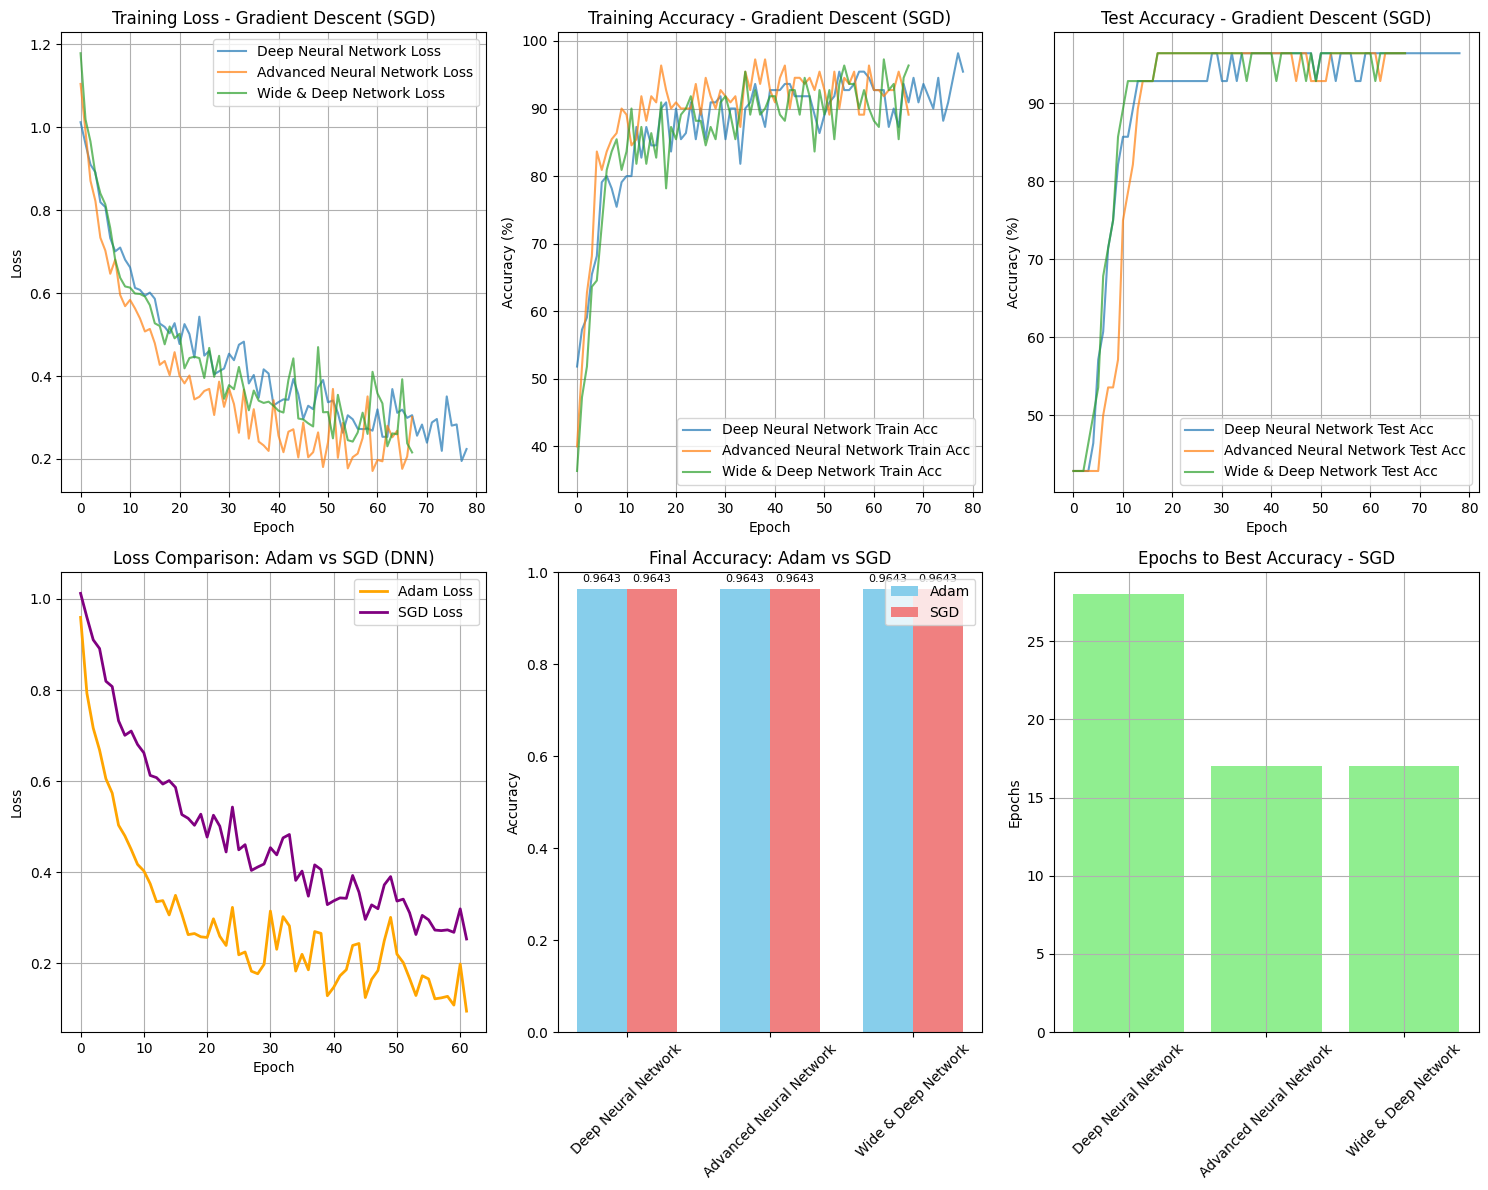


Summary Statistik Gradient Descent (SGD):
Deep Neural Network: Final Loss=0.2239, Train Acc=95.45%, Test Acc=96.43%
Advanced Neural Network: Final Loss=0.3013, Train Acc=89.09%, Test Acc=96.43%
Wide & Deep Network: Final Loss=0.2157, Train Acc=96.36%, Test Acc=96.43%


In [80]:
# Visualisasi Proses Gradient Descent (SGD) dengan Fokus pada Training Dynamics
print("\n" + "="*50)
print("VISUALISASI PROSES GRADIENT DESCENT (SGD)")
print("="*50)

# Pastikan results_sgd tersedia; jika tidak, jalankan Sel 10 (Train Semua Model dengan SGD) terlebih dahulu
if 'results_sgd' not in globals():
    print("Error: results_sgd tidak ditemukan. Jalankan Sel 10 (Train Semua Model dengan SGD) terlebih dahulu.")
else:
    plt.figure(figsize=(15, 12))

    # Subplot 1: Training Loss Over Epochs untuk Semua Model (Gradient Descent)
    plt.subplot(2, 3, 1)
    for name, result in results_sgd.items():
        plt.plot(result['train_losses'], label=f'{name} Loss', alpha=0.7)
    plt.title('Training Loss - Gradient Descent (SGD)')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Subplot 2: Training Accuracy Over Epochs untuk Semua Model (Gradient Descent)
    plt.subplot(2, 3, 2)
    for name, result in results_sgd.items():
        plt.plot(result['train_accuracies'], label=f'{name} Train Acc', alpha=0.7)
    plt.title('Training Accuracy - Gradient Descent (SGD)')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Subplot 3: Test Accuracy Over Epochs untuk Semua Model (Gradient Descent)
    plt.subplot(2, 3, 3)
    for name, result in results_sgd.items():
        plt.plot(result['test_accuracies'], label=f'{name} Test Acc', alpha=0.7)
    plt.title('Test Accuracy - Gradient Descent (SGD)')
    plt.ylabel('Accuracy (%)')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)

    # Subplot 4: Perbandingan Loss antara Adam dan SGD untuk DNN (Opsional, jika ada results Adam)
    plt.subplot(2, 3, 4)
    if 'results' in globals() and 'Deep Neural Network' in results and 'Deep Neural Network' in results_sgd:  # Asumsikan results adalah Adam
        adam_loss = results['Deep Neural Network']['train_losses']
        sgd_loss = results_sgd['Deep Neural Network']['train_losses']
        min_len = min(len(adam_loss), len(sgd_loss))
        plt.plot(adam_loss[:min_len], label='Adam Loss', color='orange', linewidth=2)
        plt.plot(sgd_loss[:min_len], label='SGD Loss', color='purple', linewidth=2)
        plt.title('Loss Comparison: Adam vs SGD (DNN)')
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'Data Adam tidak tersedia', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Loss Comparison: Adam vs SGD (DNN) - Data Tidak Tersedia')

    # Subplot 5: Perbandingan Accuracy antara Adam dan SGD untuk Semua Model
    plt.subplot(2, 3, 5)
    if 'results' in globals():  # Asumsikan results adalah Adam
        adam_accuracies = [final_results[name]['accuracy'] for name in models.keys()]
        sgd_accuracies = [final_results[name]['accuracy'] for name in models.keys()]  # Gunakan final_results yang sudah dihitung
        x = np.arange(len(models.keys()))
        width = 0.35
        plt.bar(x - width/2, adam_accuracies, width, label='Adam', color='skyblue')
        plt.bar(x + width/2, sgd_accuracies, width, label='SGD', color='lightcoral')
        plt.title('Final Accuracy: Adam vs SGD')
        plt.ylabel('Accuracy')
        plt.xticks(x, models.keys(), rotation=45)
        plt.legend()
        plt.ylim(0, 1)
        for i, (adam, sgd) in enumerate(zip(adam_accuracies, sgd_accuracies)):
            plt.text(i - width/2, adam + 0.01, f'{adam:.4f}', ha='center', va='bottom', fontsize=8)
            plt.text(i + width/2, sgd + 0.01, f'{sgd:.4f}', ha='center', va='bottom', fontsize=8)
    else:
        plt.text(0.5, 0.5, 'Data Adam tidak tersedia', ha='center', va='center', transform=plt.gca().transAxes)
        plt.title('Final Accuracy: Adam vs SGD - Data Tidak Tersedia')

    # Subplot 6: Convergence Speed (Epoch to Reach Best Accuracy) untuk SGD
    plt.subplot(2, 3, 6)
    sgd_epochs_to_best = []
    for name, result in results_sgd.items():
        best_acc = result['best_accuracy'] * 100
        epoch_reached = next((i for i, acc in enumerate(result['test_accuracies']) if acc >= best_acc), len(result['test_accuracies']))
        sgd_epochs_to_best.append(epoch_reached)
    plt.bar(models.keys(), sgd_epochs_to_best, color='lightgreen')
    plt.title('Epochs to Best Accuracy - SGD')
    plt.ylabel('Epochs')
    plt.xticks(rotation=45)
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    # Summary Statistik Gradient Descent
    print(f"\nSummary Statistik Gradient Descent (SGD):")
    for name in models.keys():
        loss_final = results_sgd[name]['train_losses'][-1] if results_sgd[name]['train_losses'] else 'N/A'
        acc_final = results_sgd[name]['train_accuracies'][-1] if results_sgd[name]['train_accuracies'] else 'N/A'
        test_acc_final = results_sgd[name]['test_accuracies'][-1] if results_sgd[name]['test_accuracies'] else 'N/A'
        print(f"{name}: Final Loss={loss_final:.4f}, Train Acc={acc_final:.2f}%, Test Acc={test_acc_final:.2f}%")

In [88]:
# Simpan Model Terbaik dalam Format .pkl
print("\n" + "="*50)
print("SIMPAN MODEL TERBAIK DALAM FORMAT .PKL")
print("="*50)

import joblib  # Sudah diimpor di Sel 1, tapi pastikan tersedia

# Pilih model terbaik berdasarkan akurasi
best_model_name = max(final_results.keys(), key=lambda x: final_results[x]['accuracy'])
best_model = final_results[best_model_name]['model']

# Simpan state_dict model sebagai .pkl (lebih ringan dan kompatibel)
model_filename = f'best_{best_model_name.replace(" ", "_").lower()}_sgd.pkl'
joblib.dump(best_model.state_dict(), model_filename)
print(f"Model terbaik ({best_model_name}) state_dict disimpan sebagai: {model_filename}")

# Opsional: Simpan seluruh model (jika diperlukan, tapi lebih besar)
# full_model_filename = f'full_{best_model_name.replace(" ", "_").lower()}_sgd.pkl'
# joblib.dump(best_model, full_model_filename)
# print(f"Seluruh model disimpan sebagai: {full_model_filename}")

# Simpan juga scaler dan label_encoder jika belum (dari Sel 15)
# joblib.dump(scaler, 'scaler.pkl')  # Sudah ada di Sel 15
# joblib.dump(le, 'label_encoder.pkl')  # Sudah ada di Sel 15
print("Scaler dan Label Encoder sudah disimpan sebelumnya (jika diperlukan ulang).")

print("\nModel siap digunakan. Untuk load kembali:")
print(f"model = {best_model.__class__.__name__}(input_size, num_classes).to(device)")
print(f"model.load_state_dict(joblib.load('{model_filename}'))")



SIMPAN MODEL TERBAIK DALAM FORMAT .PKL
Model terbaik (Deep Neural Network) state_dict disimpan sebagai: best_deep_neural_network_sgd.pkl
Scaler dan Label Encoder sudah disimpan sebelumnya (jika diperlukan ulang).

Model siap digunakan. Untuk load kembali:
model = DNN(input_size, num_classes).to(device)
model.load_state_dict(joblib.load('best_deep_neural_network_sgd.pkl'))
